In [1]:
import os
import torch
from matplotlib import pyplot
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
# 模型定义
class CNN(Module):
    # 定义模型属性
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        # 输入到隐层 1
        self.hidden1 = Conv2d(n_channels, 32, (3,3))
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # 池化层 1
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        # 隐层 2
        self.hidden2 = Conv2d(32, 32, (3,3))
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # 池化层 2
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        # 全连接层
        self.hidden3 = Linear(5*5*32, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # 输出层
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)
 
    # 前向传播
    def forward(self, X):
        # 输入到隐层 1
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        # 隐层 2
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        # 扁平化
        X = X.view(-1, 4*4*50)
        # 隐层 3
        X = self.hidden3(X)
        X = self.act3(X)
        # 输出层
        X = self.hidden4(X)
        X = self.act4(X)
        return X
 
# 准备数据集
def prepare_data(path):
    # 定义标准化，0.1307，0.3081为MNIST数据的均值和标准差
    trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    # 加载数据集
    train = MNIST(path, train=True, download=True, transform=trans)# 自动下载训练数据集、测试数据集
    test = MNIST(path, train=False, download=True, transform=trans)
    # 为训练集和测试集创建 DataLoader
    train_dl = DataLoader(train, batch_size=64, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    # 以 batch 方式获取图片
    i, (inputs, targets) = next(enumerate(train_dl))
    # 绘图
    for i in range(25):
        # 定义子图
        pyplot.subplot(5, 5, i+1)
        # 绘制原始像素数据
        pyplot.imshow(inputs[i][0], cmap='gray')
    print("Data loading...")
    # 展示图片
    pyplot.show()
    return train_dl, test_dl
 
# 训练模型
def train_model(train_dl, model):
    # 定义优化器
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # 枚举 epochs
    for epoch in range(10):
        # 枚举 mini batches
        # print("Train Epoch: %d" % epoch)
        for i, (inputs, targets) in enumerate(train_dl):
            # 梯度清除
            optimizer.zero_grad()
            # 计算模型输出
            yhat = model(inputs)
            # 计算损失
            loss = criterion(yhat, targets)
            # 贡献度分配
            loss.backward()
            # 升级模型权重
            optimizer.step()
            if i % 200 == 0:
                print('Train Epoch: {} [{:5d}/{} ({:2.0f}%)]'.format(epoch, i * len(inputs),len(train_dl.dataset),100. * i / len(train_dl)))
 
# 评估模型
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # 在测试集上评估模型
        yhat = model(inputs)
        # 转化为 numpy 数据类型
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # 转化为类标签
        yhat = argmax(yhat, axis=1)
        # 为 stack 格式化数据集
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # 保存
        predictions.append(yhat)
        actuals.append(actual)
        
    predictions, actuals = vstack(predictions), vstack(actuals)
    # 计算准确度
    acc = accuracy_score(actuals, predictions)
    return acc

Data loading...


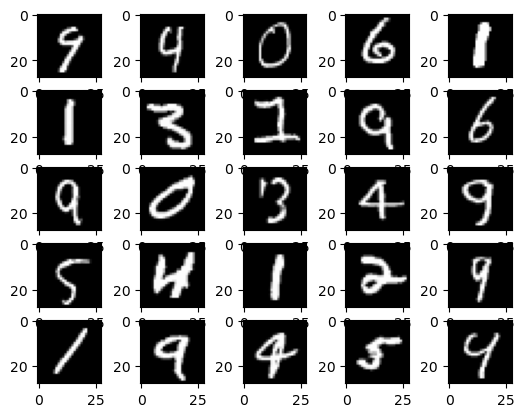

Number of training samples: 60000
Number of test samples: 10000


In [2]:
# 准备数据
path = os.path.join(os.getcwd(), 'datasets/mnist')
train_dl, test_dl = prepare_data(path)
print("Number of training samples:", len(train_dl.dataset))
print("Number of test samples:", len(test_dl.dataset))

In [3]:
# 定义网络
model = CNN(1)
print("CNN Network Definition Complete")


CNN Network Definition Complete


In [4]:
# 训练模型
print("Training starts")
train_model(train_dl, model) 
print("CNN Network Training Complete")

Training starts
Train Epoch: 0 [    0/60000 ( 0%)]
Train Epoch: 0 [12800/60000 (21%)]
Train Epoch: 0 [25600/60000 (43%)]
Train Epoch: 0 [38400/60000 (64%)]
Train Epoch: 0 [51200/60000 (85%)]
Train Epoch: 1 [    0/60000 ( 0%)]
Train Epoch: 1 [12800/60000 (21%)]
Train Epoch: 1 [25600/60000 (43%)]
Train Epoch: 1 [38400/60000 (64%)]
Train Epoch: 1 [51200/60000 (85%)]
Train Epoch: 2 [    0/60000 ( 0%)]
Train Epoch: 2 [12800/60000 (21%)]
Train Epoch: 2 [25600/60000 (43%)]
Train Epoch: 2 [38400/60000 (64%)]
Train Epoch: 2 [51200/60000 (85%)]
Train Epoch: 3 [    0/60000 ( 0%)]
Train Epoch: 3 [12800/60000 (21%)]
Train Epoch: 3 [25600/60000 (43%)]
Train Epoch: 3 [38400/60000 (64%)]
Train Epoch: 3 [51200/60000 (85%)]
Train Epoch: 4 [    0/60000 ( 0%)]
Train Epoch: 4 [12800/60000 (21%)]
Train Epoch: 4 [25600/60000 (43%)]
Train Epoch: 4 [38400/60000 (64%)]
Train Epoch: 4 [51200/60000 (85%)]
Train Epoch: 5 [    0/60000 ( 0%)]
Train Epoch: 5 [12800/60000 (21%)]
Train Epoch: 5 [25600/60000 (43%)]
Trai

In [5]:
# 评估模型
acc = evaluate_model(test_dl, model)
print('CNN Network accuracy: %.3f%%' % (acc * 100))

CNN Network accuracy: 98.850%


In [6]:
# 导出模型
model_path = os.path.join(os.getcwd(), 'model_path/cnn_model.pth')
torch.save(model.state_dict(), model_path)
print(f'Model successfully saved to {model_path}')

Model successfully saved to C:\Users\ASUS\Documents\CodeCargo\ezCNN\model_path/cnn_model.pth


Data loading...


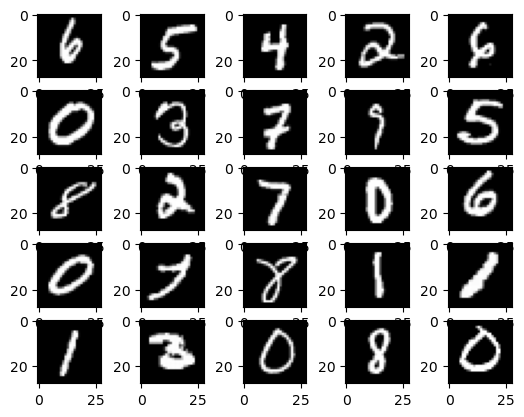

Number of training samples: 60000
Number of test samples: 10000
CNN Network Definition Complete
Model training...
CNN Network Training Complete
CNN Network accuracy: 0.988


In [1]:
import os  
from matplotlib import pyplot  
from numpy import vstack  
from numpy import argmax  
from pandas import read_csv  
from sklearn.metrics import accuracy_score  
from torchvision.datasets import MNIST  
from torchvision.transforms import Compose, ToTensor, Normalize  
from torch.utils.data import DataLoader  
from torch.nn import Conv2d, MaxPool2d, Linear, ReLU, Softmax, Module  
from torch.optim import SGD  
from torch.nn import CrossEntropyLoss  
from torch.nn.init import kaiming_uniform_, xavier_uniform_  
import torch

# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 模型定义  
class CNN(Module):  
    # 定义模型属性  
    def __init__(self, n_channels):  
        super(CNN, self).__init__()  
        self.hidden1 = Conv2d(n_channels, 32, (3,3))  
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')  
        self.act1 = ReLU()  
        self.pool1 = MaxPool2d((2,2), stride=(2,2))  
        self.hidden2 = Conv2d(32, 32, (3,3))  
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')  
        self.act2 = ReLU()  
        self.pool2 = MaxPool2d((2,2), stride=(2,2))  
        self.hidden3 = Linear(5*5*32, 100)  
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')  
        self.act3 = ReLU()  
        self.hidden4 = Linear(100, 10)  
        xavier_uniform_(self.hidden4.weight)  
        self.act4 = Softmax(dim=1)  

    # 前向传播  
    def forward(self, X):  
        X = self.hidden1(X)  
        X = self.act1(X)  
        X = self.pool1(X)  
        X = self.hidden2(X)  
        X = self.act2(X)  
        X = self.pool2(X)  
        X = X.view(-1, 5*5*32)  
        X = self.hidden3(X)  
        X = self.act3(X)  
        X = self.hidden4(X)  
        X = self.act4(X)  
        return X  

# 准备数据集  
def prepare_data(path):  
    trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])  
    train = MNIST(path, train=True, download=True, transform=trans)  
    test = MNIST(path, train=False, download=True, transform=trans)  
    train_dl = DataLoader(train, batch_size=64, shuffle=True)  
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)  
    i, (inputs, targets) = next(enumerate(train_dl))  
    for i in range(25):  
        pyplot.subplot(5, 5, i+1)  
        pyplot.imshow(inputs[i][0], cmap='gray')  
    print("Data loading...")  
    pyplot.show()  
    return train_dl, test_dl  

# 训练模型  
def train_model(train_dl, model):  
    criterion = CrossEntropyLoss()  
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)  
    for epoch in range(10):  
        for i, (inputs, targets) in enumerate(train_dl):  
            inputs, targets = inputs.to(device), targets.to(device)  # 将数据转移到GPU
            optimizer.zero_grad()  
            yhat = model(inputs)  
            loss = criterion(yhat, targets)  
            loss.backward()  
            optimizer.step()  

# 评估模型  
def evaluate_model(test_dl, model):  
    predictions, actuals = list(), list()  
    for i, (inputs, targets) in enumerate(test_dl):  
        inputs, targets = inputs.to(device), targets.to(device)  # 将数据转移到GPU
        yhat = model(inputs)  
        yhat = yhat.detach().cpu().numpy()  # 将结果转移回CPU进行计算  
        actual = targets.cpu().numpy()  
        yhat = argmax(yhat, axis=1)  
        actual = actual.reshape((len(actual), 1))  
        yhat = yhat.reshape((len(yhat), 1))  
        predictions.append(yhat)  
        actuals.append(actual)  
          
    predictions, actuals = vstack(predictions), vstack(actuals)  
    acc = accuracy_score(actuals, predictions)  
    return acc  

# 准备数据  
path = os.path.join(os.getcwd(), 'datasets/mnist')  
train_dl, test_dl = prepare_data(path)  
print("Number of training samples:", len(train_dl.dataset))  
print("Number of test samples:", len(test_dl.dataset))  

# 定义网络并移动到GPU
model = CNN(1).to(device)
print("CNN Network Definition Complete")  

# 训练模型  
print("Model training...")  
train_model(train_dl, model)  
print("CNN Network Training Complete")  

# 评估模型  
acc = evaluate_model(test_dl, model)  
print('CNN Network accuracy: %.3f' % acc)
